In [24]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
import os, sys
from os.path import join as pjoin
print('cwd: ', os.getcwd())
sys.path.insert(0, pjoin(os.path.pardir, 'webapi'))
sys.path.insert(0, pjoin(os.path.pardir, os.path.pardir, 'mcdose'))
import numpy as np
import h5py
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from tqdm import tqdm

os.environ['CUDA_VISIBLE_DEVICES'] = ""
%aimport mcdose

cwd:  /home/ryan/projects/MCDoseDenoiser/dosecalc/jupyter_notebooks


In [234]:
%aimport mcdose.visualize
from mcdose.visualize import vis_slice

In [235]:
from mcdose import get_trained_model
import json
import logging
mcdoselogger = logging.getLogger('MCDose')
mcdoselogger.addHandler(logging.StreamHandler())
mcdoselogger.setLevel(logging.DEBUG)
stats_file = '/media/hdd1/g4sim/runs_shenggpu2/0008/normstats.json'

model = get_trained_model(
    config='/media/hdd1/g4sim/runs_shenggpu2/0008/config.yml',
    weights='/media/hdd1/g4sim/runs_shenggpu2/0008/checkpoints/weights.hdf5',
    normstats=stats_file,
)
with open(stats_file, 'r') as fd:
    normstats = json.load(fd)

Config loaded from "/media/hdd1/g4sim/runs_shenggpu2/0008/config.yml"
Failed to reload model checkpoint from "/media/hdd1/g4sim/runs_shenggpu2/0008/checkpoints/weights.hdf5"


ValueError: You are trying to load a weight file containing 31 layers into a model with 17 layers.

In [5]:
def predict(inputs):
    factors = np.array(normstats['factor'][1:])[None, None, None, None, ...]
    inputs = np.multiply(inputs, factors)
    preds = model(inputs.astype(np.float32))
    return np.divide(preds[0, ..., 0], factors[...,0]) # prune sample/channel axes

In [7]:
data = np.load('/media/hdd1/g4sim/traindata/traindata_2020feb23_2k_20ctx_norm/validate/test_014.npy')
labels, inputs = data[...,0], data[...,1:]

import os
if os.path.exists('preds.npy'):
    preds = np.load('preds.npy')
else:
    from math import ceil
    batch_size = 1
    preds = np.zeros(inputs.shape[:-1])
    for batch_id in tqdm(range(ceil(len(labels)/batch_size))):
        batch_slice = slice(batch_id*batch_size, min(len(labels), (batch_id+1)*batch_size))
        xzslice = slice(10, 31)
        preds[batch_slice, xzslice, :, xzslice] = predict(inputs[batch_slice, xzslice, :, xzslice])
    np.save('preds.npy', preds)
print(labels.shape)
print(inputs.shape)
print(preds.shape)

(527, 41, 101, 41)
(527, 41, 101, 41, 2)
(527, 41, 101, 41)


In [226]:
%aimport mcdose
import mcdose.losses

loss_fn = losses.WeightedLoss(loss_cb=losses.meanabsoluteerror, weight_cb=losses.threshold_weight(thresh=0.02, mask_cval=0.0001))
weights = loss_fn.weight_cb(labels[0, None, ...,None], inputs[0, None,...,0, None])
loss = loss_fn(labels[None,0,...,None], preds[None,0,...,None])

0.118346274
(1, 41, 101, 41, 1)


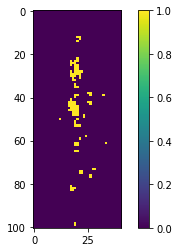

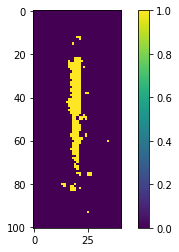

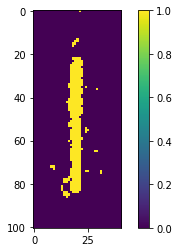

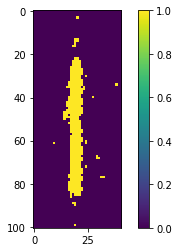

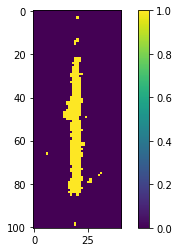

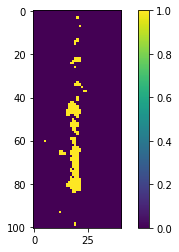

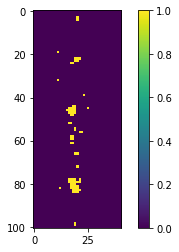

In [227]:
print(loss.numpy())
print(weights.shape)
for ii in range(17, 24):
    fig = plt.figure()
    plt.imshow(weights[0, ii, ..., 0], vmin=0, vmax=1)
    plt.colorbar()
    plt.show()


In [257]:
data = np.load('/media/hdd1/g4sim/traindata/traindata_2020feb26_2k_20ctx_norm/train/train_014.npy')
labels, inputs = data[...,0], data[...,1:]

/home/ryan/projects/MCDoseDenoiser/dosecalc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Function Fit: 908.260*exp(-7.986*x+9.025) + 3623.419


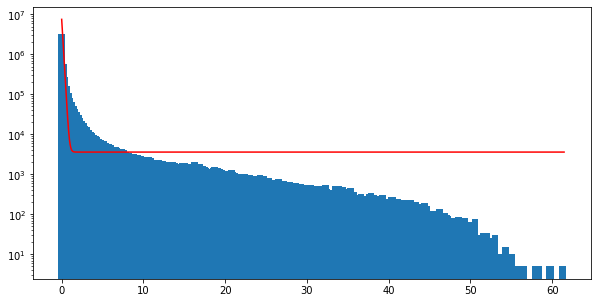

In [258]:
# Fit data distribution to exponential curve to find loss weighting decay rate
from scipy.optimize import curve_fit

def exp_fn():
    def fit_function(x, A, rate, C, B):
        return A*np.exp(-rate*x+C) + B
    fmt = '{:0.3f}*exp(-{:0.3f}*x+{:0.3f}) + {:0.3f}'
    return fit_function, fmt

def power_fn():
    def fit_function(x, A, e, C):
        return A*x**(-e)+C
    fmt = '{:0.3f}*x**(-{:0.3f}) + {:0.3f}'
    return fit_function, fmt

fit_function, fmt = exp_fn()
#fit_function, fmt = power_fn()

dmax = np.amax(labels)
bins = np.linspace(0, dmax, 300)
bincenters = np.array([0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)])

data1, bins1 = np.histogram(np.ravel(labels[:1000]), bins=bins)
popt, pcov = curve_fit(fit_function, xdata=bincenters, ydata=data1)
print("Function Fit: "+fmt.format(*popt))

# plot fit function
xspace = np.linspace(0, dmax, 100000)
fity = fit_function(xspace, *popt)


fig = plt.figure(figsize=(10,5))
plt.bar(bins1[:-1], data1)
plt.plot(xspace, fity, c='red')
plt.yscale('log')

In [244]:
# Test Log Normalization

In [297]:
data = np.load('/media/hdd1/g4sim/traindata/traindata_2020feb28_20k_14ctx_norm/train/train_000.npy')

-0.10846616


In [298]:

#log_labels, log_inputs, geom = np.log(data[...,0]), np.log(data[...,1]), data[...,2]
labels = data[...,0]
print(np.amin(labels))
print(np.amax(labels))
bins = np.linspace(np.amin(labels), np.amax(labels), 6000)
hdata, hbins = np.histogram(np.ravel(labels), bins=bins)

-0.10846616
40.41266


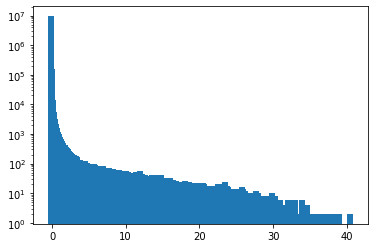

In [299]:
plt.bar(hbins[:-1], hdata)
plt.yscale('log')

In [325]:
labels = data[...,0]
print(np.amin(labels), np.amax(labels))
log_labels, log_inputs, geom = np.log((labels)+1e-9), np.log(data[...,1]+1e-9), data[...,2]
print(np.amin(log_labels))
print(np.amax(log_labels))
bins = np.linspace(np.amin(log_labels), np.amax(log_labels), 1000)
hdata, hbins = np.histogram(np.ravel(log_labels), bins=bins)
hdata2, hbins2 = np.histogram(np.ravel(log_inputs), bins=bins)

0.0 40.41266


/home/ryan/projects/MCDoseDenoiser/dosecalc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


-20.723267
3.6991432


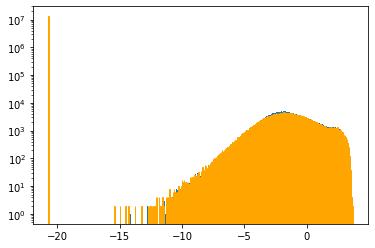

In [327]:
plt.bar(hbins[:-1], hdata, edgecolor='orange', color='none',zorder=99, width=hbins[1:]-hbins[:-1])
plt.bar(hbins2[:-1], hdata2, width=hbins2[1:]-hbins2[:-1])
plt.yscale('log')